In [6]:
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
# Read in original csv from my GitHub
initDataDf = pd.read_csv("https://raw.githubusercontent.com/JordanVencel/DFProject/main/Tesla.csv")
# Filter out tweets that are not in english 
filterDf = initDataDf[['language','tweet']]
filterDf = filterDf.where(filterDf['language'] == 'en')
filterDf = filterDf[filterDf['language'].notna()]
# Grab only tweet text data
tweetDf = filterDf['tweet'].to_frame()
tweetDf = tweetDf.reset_index(drop=True)
# Filter out @s, hashtags, external links, and other irrelavant information using regex
for row in tweetDf.iterrows():
    index = row[0]
    booty = re.sub(r"([@#])\w+", "", row[1][0])
    booty = re.sub(r"(https)([^\s]+)", "", booty)
    booty = re.sub(r"(\?)", "", booty)
    booty = re.sub(r"(.com)", "", booty)
    booty = re.sub(r"([^A-Za-z0-9'!?$\",.\s]*)", "", booty)
    booty = re.sub(r"(^[ \t]+)", "", booty)
    tweetDf.iloc[index][0] = booty

tweetDf

,tweet
0,I have six. 4 of them still live at home being...
1,Then go for your dozen kids you are just missi...
2,"about buying a country , You could turn it i..."
3,"Actual receipts, and yet you havent asked anyo..."
4,Tesla wall battery for the save! Power went ou...
...,...
7353,Elon Musk liked a tweet from Whole Mars Catalo...
7354,Dude only said he is buying twitter to sell 8 ...
7355,Give me your Tesla
7356,"Chick Fil A should definitely go public, they ..."


In [8]:
# Set up row id formatting for nltk
import sys
tweetDf['row_id'] = 0
tweetDf = tweetDf[['row_id', 'tweet']]
for row in tweetDf.iterrows():
    index = row[0]
    newVal = int(index) + 1
    tweetDf['row_id'][index] = newVal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
sentimentDf = pd.DataFrame()
sentimentDf['row_id'] = ['99999999999']
sentimentDf['sentiment_type'] = 'NA999NA'
sentimentDf['sentiment_score'] = 0

print('Processing sentiment analysis...')
sia = SentimentIntensityAnalyzer()
tempDf = sentimentDf
for index, row in tweetDf.iterrows():
    scores = sia.polarity_scores(row[1])
    for key, value in scores.items():
        temp = [key,value,row[0]]
        sentimentDf['row_id'] = row[0]
        sentimentDf['sentiment_type'] = key
        sentimentDf['sentiment_score'] = value
        tempDf = tempDf.append(sentimentDf)
#remove dummy row with row_id = 99999999999
tempDf_cleaned = tempDf[tempDf.row_id != '99999999999']
#remove duplicates if any exist
tempDf_cleaned = tempDf_cleaned.drop_duplicates()
# only keep rows where sentiment_type = compound
tempDf_cleaned = tempDf[tempDf.sentiment_type == 'compound']

print(tempDf_cleaned)

Processing sentiment analysis...
    row_id sentiment_type  sentiment_score
0        1       compound          -0.4767
0        2       compound          -0.5216
0        3       compound           0.5267
0        4       compound           0.5399
0        5       compound           0.3382
..     ...            ...              ...
0     7354       compound           0.4215
0     7355       compound          -0.0516
0     7356       compound           0.0000
0     7357       compound           0.6908
0     7358       compound           0.6124

[7358 rows x 3 columns]


In [32]:
tempDf_cleaned = tempDf_cleaned.reset_index(drop=True)
tempDf_cleaned

,row_id,sentiment_type,sentiment_score
0,1,compound,-0.4767
1,2,compound,-0.5216
2,3,compound,0.5267
3,4,compound,0.5399
4,5,compound,0.3382
...,...,...,...
7353,7354,compound,0.4215
7354,7355,compound,-0.0516
7355,7356,compound,0.0000
7356,7357,compound,0.6908


In [37]:
recombined_df = pd.DataFrame(columns=['row_id', 'tweet', 'sentiment_type', 'sentiment_score'])
recombined_df['tweet'] = tweetDf['tweet']
recombined_df[['row_id', 'sentiment_type', 'sentiment_score']] = tempDf_cleaned[['row_id', 'sentiment_type', 'sentiment_score']]
recombined_df

,row_id,tweet,sentiment_type,sentiment_score
0,1,I have six. 4 of them still live at home being...,compound,-0.4767
1,2,Then go for your dozen kids you are just missi...,compound,-0.5216
2,3,"about buying a country , You could turn it i...",compound,0.5267
3,4,"Actual receipts, and yet you havent asked anyo...",compound,0.5399
4,5,Tesla wall battery for the save! Power went ou...,compound,0.3382
...,...,...,...,...
7353,7354,Elon Musk liked a tweet from Whole Mars Catalo...,compound,0.4215
7354,7355,Dude only said he is buying twitter to sell 8 ...,compound,-0.0516
7355,7356,Give me your Tesla,compound,0.0000
7356,7357,"Chick Fil A should definitely go public, they ...",compound,0.6908


In [38]:
from gensim.models import Word2Vec, FastText
import pandas as pd 
import re 

from sklearn.decomposition import PCA

from matplotlib import  pyplot as plt 
import plotly.graph_objects as go 

import numpy as np 
import warnings 
warnings.filterwarnings('ignore')

In [48]:
w2v = Word2Vec(recombined_df['tweet'], min_count=5, vector_size=5)
print(w2v)

Word2Vec(vector_size=5, alpha=0.025)

Word2Vec(vocab=70, size=5, alpha=0.025)


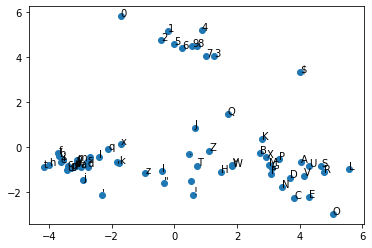

In [49]:
X = w2v.wv[w2v.wv.key_to_index]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.scatter(result[:, 0], result[:, 1])
words = list(w2v.wv.key_to_index)

for i, word in enumerate(words):
  plt.annotate(word, xy=(result[i, 0], result[i,1]))

plt.show()